## Set up

In [1]:
# imports
import mne
mne.set_log_level('WARNING')
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import yasa
import math
from collections import Counter
from mne.preprocessing import annotate_muscle_zscore


In [2]:
# functions

# entropy feature function
def eta(data, unit='natural'):
    base = {
        'shannon' : 2.,
        'natural' : math.exp(1),
        'hartley' : 10.
    }
    if len(data) <= 1:
        return 0
    counts = Counter()
    for d in data:
        counts[d] += 1
    ent = 0
    probs = [float(c) / len(data) for c in counts.values()]
    for p in probs:
        if p > 0.:
            ent -= p * math.log(p, base[unit])
    return ent

# Plot raw EEG function (plots 5 signals)
def visualize_sample_eeg(signals):
# Extract data from the first 5 channels, from 1 s to 3 s.
    sfreq = signals.info['sfreq']
    time_range=100
    how_many_channels=5
    data, times = signals[:how_many_channels, int(sfreq * 1):int(sfreq * time_range)]

    fig = plt.subplots(figsize=(15,5))
    plt.plot(times, data.T);
    plt.xlabel('Seconds')
    plt.ylabel('$\mu V$')
    plt.title('Channels: 1-5');
    plt.legend(signals.ch_names[:how_many_channels]);
    plt.show()
    plt.tight_layout()
    return()

## READ PHYSIONET MAT FILE

In [43]:
# mat file locationand imports
fname = r'C:\Users\sendm\Downloads\EEG-plotting-code-main\ICARE_0284_05.mat'
mat = np.asarray(scipy.io.loadmat(fname)['val'])


In [45]:
# Create MNE object
n_channels = 18 # bipolar
sampling_freq = 100  # in Hertz
ch_names =  ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1',  'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'Fz-Cz', 'Cz-Pz']
ch_types =['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
# create MNE object
info = mne.create_info(sfreq=sampling_freq,ch_names=ch_names, ch_types=ch_types,)
print(info)
eeg_raw = mne.io.RawArray(mat, info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1-F7, F7-T3, T3-T5, T5-O1, Fp2-F8, F8-T4, T4-T6, T6-O2, ...
 chs: 18 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 18
 projs: []
 sfreq: 100.0 Hz
>


## EEG Plotting

### plotting raw EEG

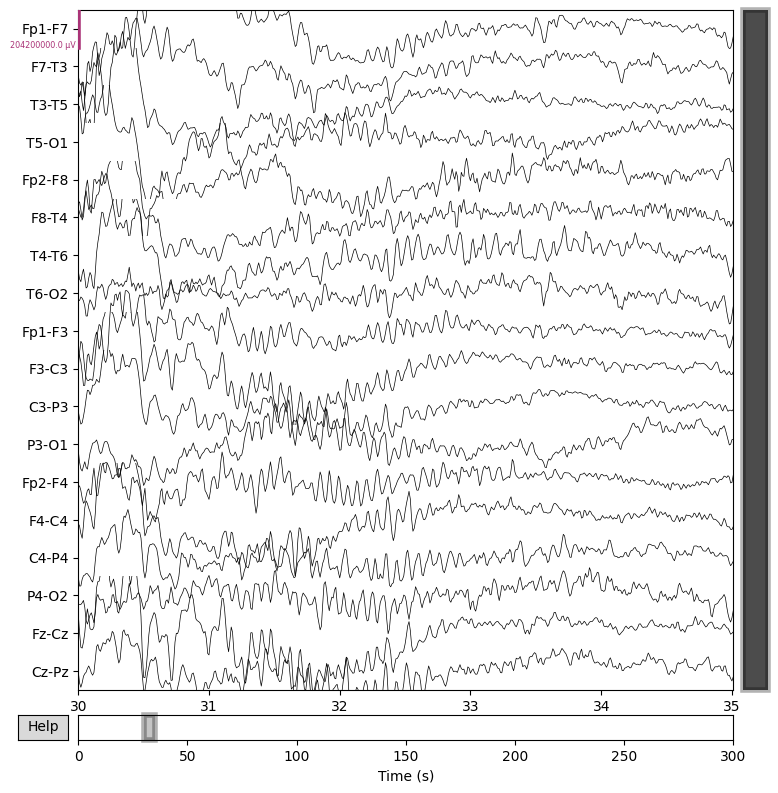

Figure(800x800)


In [46]:
# plot raw EEG signals
print(eeg_raw.plot(start=30,duration=5, scalings='auto'))

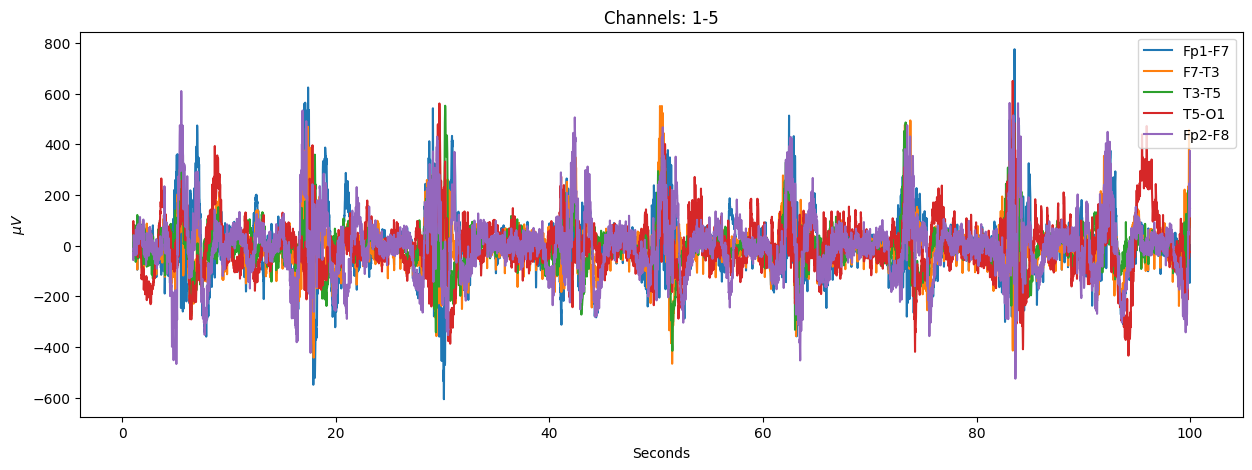

()

<Figure size 640x480 with 0 Axes>

In [47]:
# plot overlapping raw EEG signals
visualize_sample_eeg(eeg_raw)

### plotting spectrogram eeg

C:\Users\sendm\AppData\Local\Temp\ipykernel_3540\37021419.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  print(eeg_raw.plot_psd())
C:\Users\sendm\AppData\Local\Temp\ipykernel_3540\37021419.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  print(eeg_raw.plot_psd())
c:\Users\sendm\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Figure(1000x350)


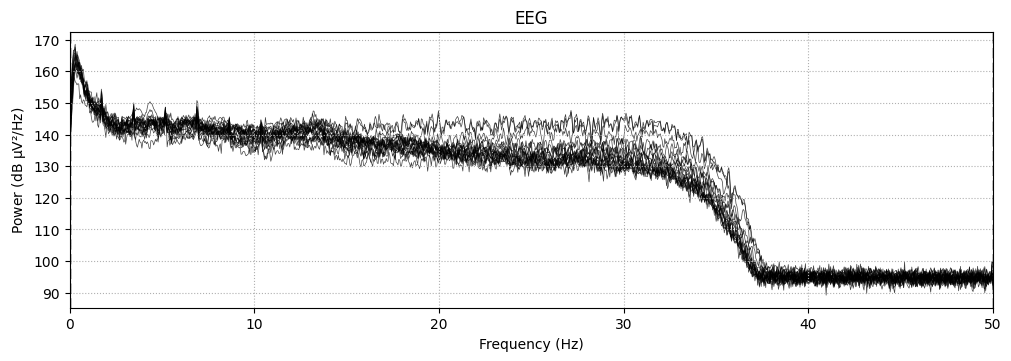

In [48]:
# plot power spectral density
print(eeg_raw.plot_psd())

Figure(1200x400)


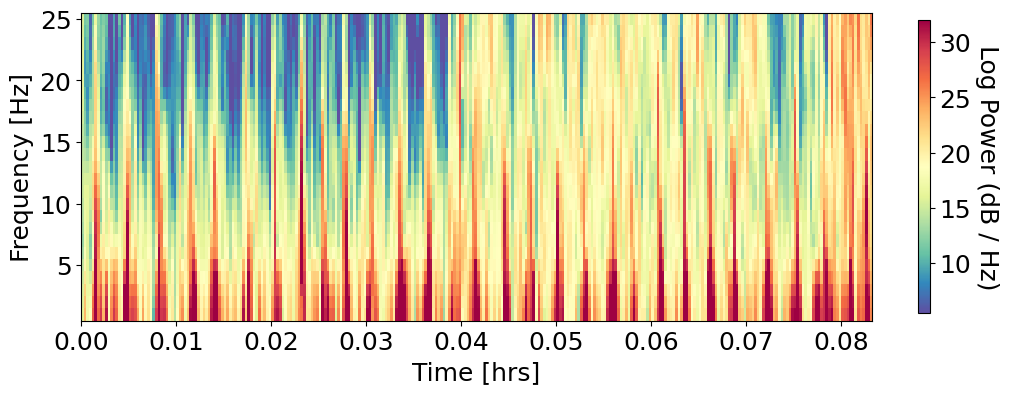

In [49]:
# plots spectrogram PER channel (please pick channel #)
pick_channel_num = 1;
eeg_sample_points = 30000
win_sec = 1
sfreq= 100
data, times = eeg_raw[pick_channel_num, :eeg_sample_points]
data = data.flatten()
print(yasa.plot_spectrogram(data, sfreq,cmap='Spectral_r',win_sec=win_sec))

##  Artifact analysis

### muscle artifact
#### https://mne.tools/stable/auto_examples/preprocessing/muscle_detection.html

In [50]:
# The threshold is data dependent, check the optimal threshold by plotting
# ``scores_muscle``.
threshold_muscle = 7  # z-score check different values
# select channel type for muscle activity.
annot_muscle, scores_muscle = annotate_muscle_zscore(eeg_raw, ch_type="eeg", threshold=threshold_muscle,filter_freq=(0.5, 40))

[Text(0.5, 0, 'time(s)'),
 Text(0, 0.5, 'z-score'),
 Text(0.5, 1.0, 'Muscle activity')]

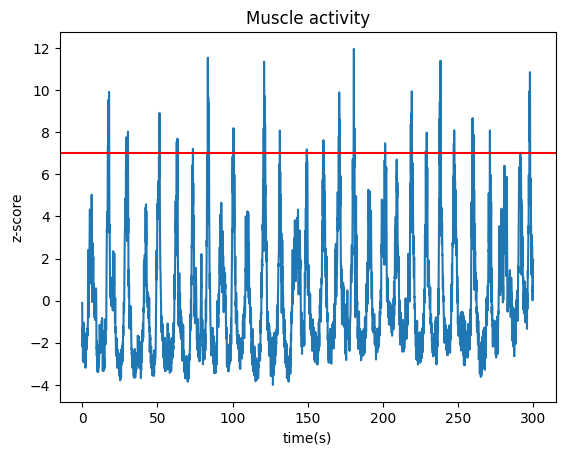

In [51]:
#Plot muscle z-scores across recording¶
fig, ax = plt.subplots()
ax.plot(eeg_raw.times, scores_muscle)
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time(s)', ylabel='z-score', title='Muscle activity')

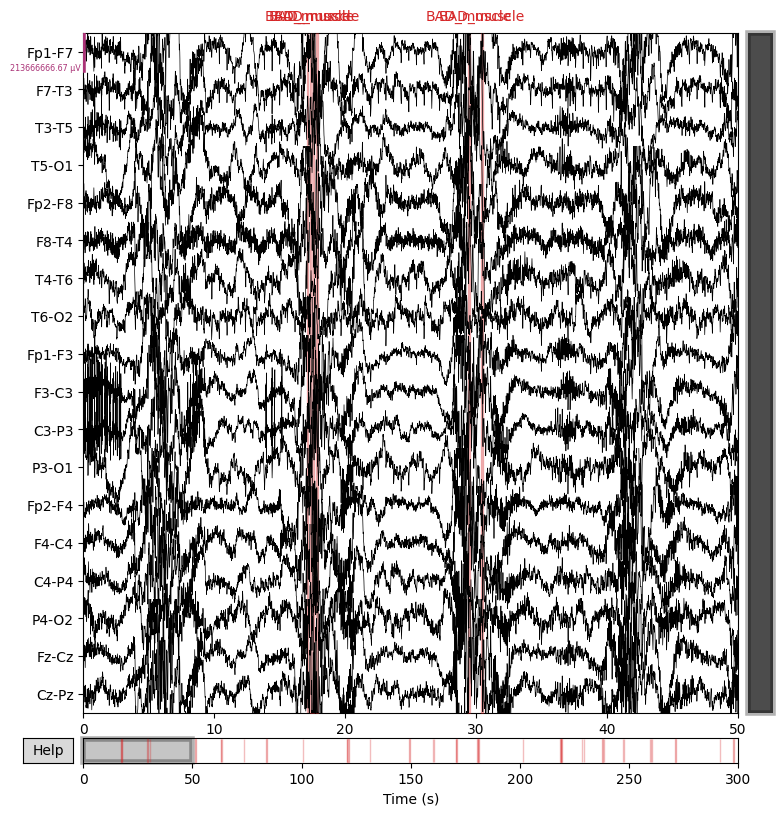

In [52]:
# View the annotations for the muscle artifact (try with epochs)
eeg_raw.set_annotations(annot_muscle)
#%matplotlib qt
eeg_raw.plot(duration=50,scalings='auto',n_channels=len(eeg_raw.ch_names));

## EEG features extraction

In [55]:
# Frequency features
channel_names = eeg_raw.ch_names
data, times = eeg_raw[:, :30000]
channel_num = 18
sfreq = 100
delta_array = []
alpha_array = []
entropy_array = []
# calculates delta, alpha and entropy for each channel and saves values in arrays for plotting
for channel in range(0,channel_num):
    EEG = eeg_raw
    EEG, times = eeg_raw[channel, :30000]
    EEG = EEG.flatten()
    chan_name = channel_names[channel]

    # DELTA
    Y = mne.time_frequency.psd_array_welch(EEG,sfreq=sfreq,fmin=0.5,fmax=4,verbose=False)
    P1 = Y[0] 
    X1 = np.mean(P1)
    delta_array.append(X1)

    Y2 = mne.time_frequency.psd_array_welch(EEG,sfreq=sfreq,fmin=8,fmax=12,verbose=False)    
    P2 = Y2[0] 
    X2 = np.mean(P2)
    alpha_array.append(X2)

    entropy_chan = eta(EEG) 
    entropy_array.append(entropy_chan)
    print("For channel %s: delta is %d. alpha is %d. entropy is %d" % (chan_name, X1,X2,entropy_chan))

    

For channel Fp1-F7: delta is 1684. alpha is 165. entropy is 6
For channel F7-T3: delta is 1108. alpha is 121. entropy is 5
For channel T3-T5: delta is 688. alpha is 83. entropy is 5
For channel T5-O1: delta is 964. alpha is 59. entropy is 6
For channel Fp2-F8: delta is 1858. alpha is 158. entropy is 6
For channel F8-T4: delta is 780. alpha is 104. entropy is 5
For channel T4-T6: delta is 1534. alpha is 99. entropy is 6
For channel T6-O2: delta is 396. alpha is 45. entropy is 5
For channel Fp1-F3: delta is 879. alpha is 137. entropy is 5
For channel F3-C3: delta is 1051. alpha is 226. entropy is 6
For channel C3-P3: delta is 672. alpha is 169. entropy is 5
For channel P3-O1: delta is 1025. alpha is 102. entropy is 6
For channel Fp2-F4: delta is 1383. alpha is 145. entropy is 6
For channel F4-C4: delta is 1333. alpha is 165. entropy is 6
For channel C4-P4: delta is 863. alpha is 121. entropy is 5
For channel P4-O2: delta is 783. alpha is 96. entropy is 5
For channel Fz-Cz: delta is 1413.

Text(0.5, 1.0, 'Average delta values per channel')

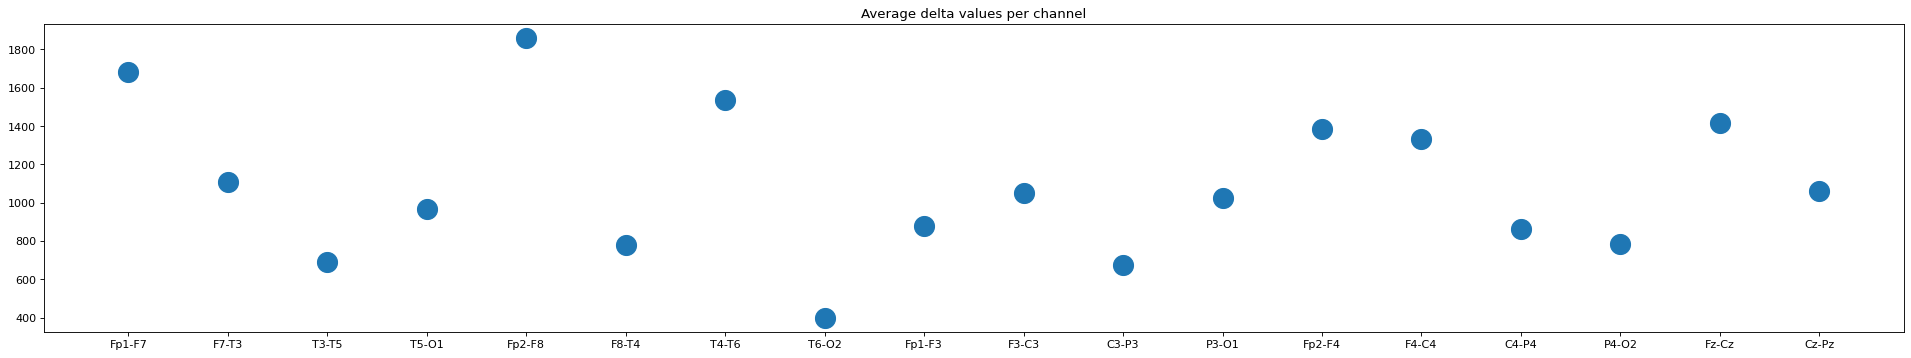

In [57]:
figure(figsize=(30, 5), dpi=80)
plt.plot(channel_names,delta_array,'o',ms = 18)
plt.title("Average delta values per channel")

## Resources

In [267]:
#specific mne package for extracting feature and prep for ML: #https://mne.tools/mne-features/ 
#preprocessing: #https://mne.tools/dev/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py 
#workshop: #https://github.com/mne-tools/mne-workshops/blob/master/2018_06_Amsterdam/mne_notebook_1_preproc.ipynb